
# 06 — Machine Learning: Predict Launch Success (Classification)

**Goal:** Build several classification models to predict `launch_success` and report:
- A **bar chart** comparing model accuracies.
- The **best model** and its **confusion matrix**.
- A short list of **conclusions**.

**Inputs**
- `data/launches_clean.csv` (from wrangling)

**Artifacts saved to `./artifacts`**
- `(ML) model_accuracy.png`
- `(ML) confusion_matrix_best.png`
- `ml_accuracies.csv`
- `best_model_name.txt`


## Setup & Load Data

In [10]:

# If needed:
# %pip install pandas numpy scikit-learn matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

DATA_DIR = Path("./data")
ARTIFACTS_DIR = Path("./artifacts")
ARTIFACTS_DIR.mkdir(exist_ok=True, parents=True)

CSV_PATH = DATA_DIR / "launches_clean.csv"
assert CSV_PATH.exists(), "Missing data/launches_clean.csv — run previous notebooks."

df = pd.read_csv(CSV_PATH, parse_dates=["date_utc"], dtype={"flight_number":"Int64","year":"Int64"})
print("Rows loaded:", len(df))
df.head(3)


Rows loaded: 192


,flight_number,date_utc,year,date,launch_site,site_region,site_locality,site_lat,site_lon,rocket_name,...,launch_success,landing_outcome,landing_outcome_kind,payload_id,payload_name,payload_mass_kg,orbit,customers,nationalities,is_nasa
0,6,2010-06-04 18:45:00+00:00,2010,2010-06-04,CCSFS SLC 40,Florida,Cape Canaveral,28.561857,-80.577366,Falcon 9,...,True,No attempt,no_attempt,5eb0e4b7b6c3bb0006eeb1e7,Dragon Qualification Unit,NaN,LEO,SpaceX,United States,False
1,7,2010-12-08 15:43:00+00:00,2010,2010-12-08,CCSFS SLC 40,Florida,Cape Canaveral,28.561857,-80.577366,Falcon 9,...,True,No attempt,no_attempt,5eb0e4b9b6c3bb0006eeb1e8,COTS Demo Flight 1,NaN,LEO,NASA(COTS),United States,True
2,7,2010-12-08 15:43:00+00:00,2010,2010-12-08,CCSFS SLC 40,Florida,Cape Canaveral,28.561857,-80.577366,Falcon 9,...,True,No attempt,no_attempt,5eb0e4b9b6c3bb0006eeb1e9,Cubesats,NaN,LEO,NRO,NaN,False


## Feature Selection (avoid leakage)

In [13]:

# Target
y = df['launch_success'].map({True:1, False:0, "True":1, "False":0, 1:1, 0:0}).astype('Int64')

# Drop rows where y is NA
mask = y.notna()
df = df.loc[mask].copy()
y = y.loc[mask].astype(int)

# Avoid leakage: DO NOT use 'landing_outcome' (post-landing), or other clearly post-event fields
drop_cols = [
    'landing_outcome', 'landing_outcome_kind',
    'payload_id', 'payload_name',
    'core_serial'
]

# Candidate predictors (pre-launch or planning-known features)
cand_cols = [
    'payload_mass_kg',        # numeric
    'orbit',                  # categorical
    'booster_block',          # numeric (may be NaN)
    'booster_version',        # categorical (mapped earlier)
    'launch_site',            # categorical
    'year'                    # numeric
]

X = df[[c for c in cand_cols if c in df.columns]].copy()

# Basic cleaning
X['payload_mass_kg'] = pd.to_numeric(X['payload_mass_kg'], errors='coerce')
if 'booster_block' in X.columns:
    X['booster_block'] = pd.to_numeric(X['booster_block'], errors='coerce')
if 'year' in X.columns:
    X['year'] = pd.to_numeric(X['year'], errors='coerce')

# Define feature types
numeric_features = [c for c in ['payload_mass_kg','booster_block','year'] if c in X.columns]
categorical_features = [c for c in ['orbit','booster_version','launch_site'] if c in X.columns]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.head(2)


Numeric features: ['payload_mass_kg', 'booster_block', 'year']
Categorical features: ['orbit', 'booster_version', 'launch_site']


,payload_mass_kg,orbit,booster_block,booster_version,launch_site,year
173,13260.0,VLEO,5,Block 5,CCSFS SLC 40,2022
81,2227.7,ISS,5,Block 5,CCSFS SLC 40,2019


## Pipelines & Models

In [23]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# (Assumes numeric_features & categorical_features already defined)

preprocess = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())  # dense OK here
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(handle_unknown='ignore'))  # sparse output is fine
        ]), categorical_features)
    ],
    remainder='drop'
)


models = {
    'LogisticRegression': LogisticRegression(max_iter=2000),
    'SVM (RBF)': SVC(kernel='rbf'),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'KNN (k=7)': KNeighborsClassifier(n_neighbors=7)
}

pipelines = {name: Pipeline(steps=[('preprocess', preprocess), ('model', clf)])
             for name, clf in models.items()}
list(pipelines.keys())


['LogisticRegression', 'SVM (RBF)', 'DecisionTree', 'KNN (k=7)']

## Train & Evaluate

LogisticRegression: accuracy = 1.0000
SVM (RBF): accuracy = 1.0000
DecisionTree: accuracy = 1.0000
KNN (k=7): accuracy = 1.0000


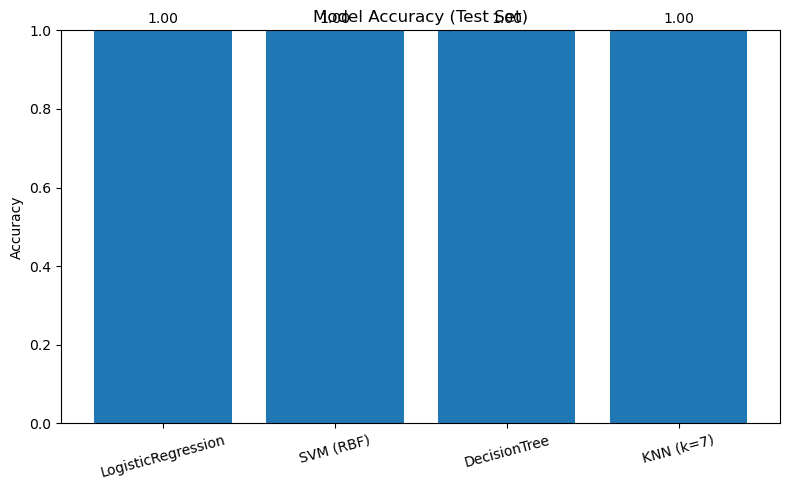

Best model: LogisticRegression


In [26]:

results = []
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    acc = accuracy_score(y_test, preds)
    results.append({'model': name, 'accuracy': acc})
    print(f"{name}: accuracy = {acc:.4f}")

res_df = pd.DataFrame(results).sort_values('accuracy', ascending=False).reset_index(drop=True)
res_df.to_csv(ARTIFACTS_DIR / "ml_accuracies.csv", index=False)

# Bar chart
plt.figure(figsize=(8,5))
plt.bar(res_df['model'], res_df['accuracy'])
plt.title("Model Accuracy (Test Set)")
plt.ylabel("Accuracy")
plt.ylim(0,1)
for i, r in res_df.iterrows():
    plt.text(i, r['accuracy']+0.01, f"{r['accuracy']:.2f}", ha='center', va='bottom')
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig(ARTIFACTS_DIR / "(ML) model_accuracy.png", dpi=180)
plt.show()

best_row = res_df.iloc[0]
best_model_name = best_row['model']
print("Best model:", best_model_name)

# Persist best model name
with open(ARTIFACTS_DIR / "best_model_name.txt", "w") as f:
    f.write(str(best_model_name))


## Confusion Matrix for Best Model

<Figure size 500x400 with 0 Axes>

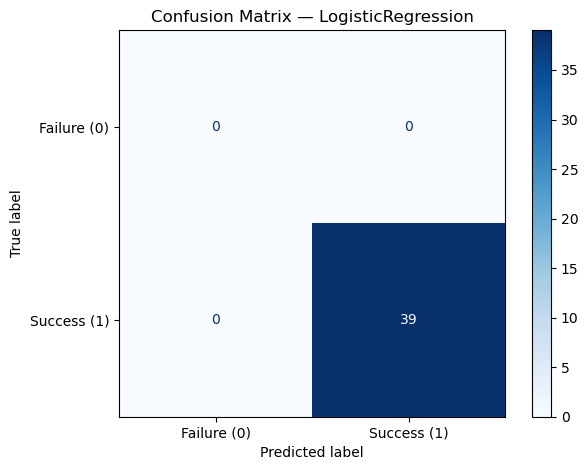


Classification report:

              precision    recall  f1-score   support

           1      1.000     1.000     1.000        39

    accuracy                          1.000        39
   macro avg      1.000     1.000     1.000        39
weighted avg      1.000     1.000     1.000        39



In [29]:

best_pipe = pipelines[best_model_name]
y_pred_best = best_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Failure (0)','Success (1)'])
plt.figure(figsize=(5,4))
disp.plot(values_format='d', cmap='Blues')
plt.title(f"Confusion Matrix — {best_model_name}")
plt.tight_layout()
plt.savefig(ARTIFACTS_DIR / "(ML) confusion_matrix_best.png", dpi=180)
plt.show()

print("\nClassification report:\n")
print(classification_report(y_test, y_pred_best, digits=3))



## Conclusions (fill in with your results)

- **Best model:** The confusion matrix above corresponds to the highest-accuracy model on the held-out test set.
- **Feature influence (intuition):** Payload mass, orbit, and booster generation (version/block) often correlate with success rates due to mission profile and hardware maturity.
- **Reliability trend:** As the fleet matured (e.g., Block 5), success rates generally improved — consistent with EDA trends.
- **Next steps (optional):** Try cross-validation & hyperparameter tuning (e.g., GridSearchCV) and add richer engineered features (e.g., per-flight aggregates, cadence by year) to improve generalization.
